In [1]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [2]:
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")

In [4]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [5]:
df.columns = ["admit", "gre", "gpa", "prestige"]

In [6]:
df.head()

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [10]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [14]:
pd.crosstab(df["admit"] , df["prestige"], rownames = ['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


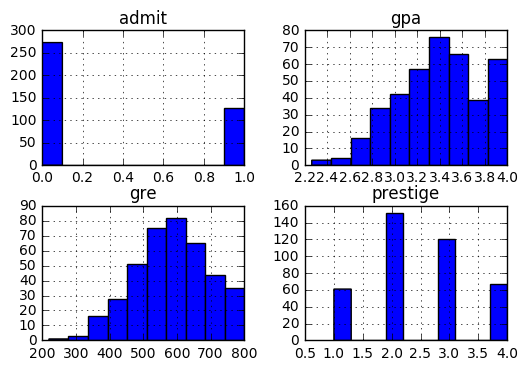

In [15]:
df.hist()
pl.show()

In [19]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix = "prestige")
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [23]:
cols_to_keep = ["admit", "gre", "gpa"]
data = df[cols_to_keep].join(dummy_ranks.ix[:, "prestige_2":])


In [24]:
data["intercept"] = 1.0

In [25]:
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1.0
1,1,660,3.67,0,1,0,1.0
2,1,800,4.00,0,0,0,1.0
3,1,640,3.19,0,0,1,1.0
4,0,520,2.93,0,0,1,1.0


In [27]:
train_cols = data.columns[1:]
train_cols

Index([u'gre', u'gpa', u'prestige_2', u'prestige_3', u'prestige_4',
       u'intercept'],
      dtype='object')

In [29]:
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


In [30]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Dec 2016   Pseudo R-squ.:                 0.08292
Time:                        20:44:40   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038         0.000     0.004
gpa            0.8040      0.332      2.423      0.015         0.154     1.454
prestige_2    -0.6754      0.316     -2.134      0.0

In [31]:
print result.conf_int()

                   0         1
gre         0.000120  0.004409
gpa         0.153684  1.454391
prestige_2 -1.295751 -0.055135
prestige_3 -2.016992 -0.663416
prestige_4 -2.370399 -0.732529
intercept  -6.224242 -1.755716


In [32]:
print np.exp(result.params) # here we see that prestige_2 drops chances by %50

gre           1.002267
gpa           2.234545
prestige_2    0.508931
prestige_3    0.261792
prestige_4    0.211938
intercept     0.018500
dtype: float64


In [34]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                2.5%     97.5%        OR
gre         1.000120  1.004418  1.002267
gpa         1.166122  4.281877  2.234545
prestige_2  0.273692  0.946358  0.508931
prestige_3  0.133055  0.515089  0.261792
prestige_4  0.093443  0.480692  0.211938
intercept   0.001981  0.172783  0.018500


In [35]:
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas


[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [41]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out
# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])

print combos.head()

     gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
0  220.0  2.260000       1.0        1.0           0           0           0   
1  220.0  2.260000       2.0        1.0           1           0           0   
2  220.0  2.260000       3.0        1.0           0           1           0   
3  220.0  2.260000       4.0        1.0           0           0           1   
4  220.0  2.453333       1.0        1.0           0           0           0   

   admit_pred  
0    0.157801  
1    0.087056  
2    0.046758  
3    0.038194  
4    0.179574  


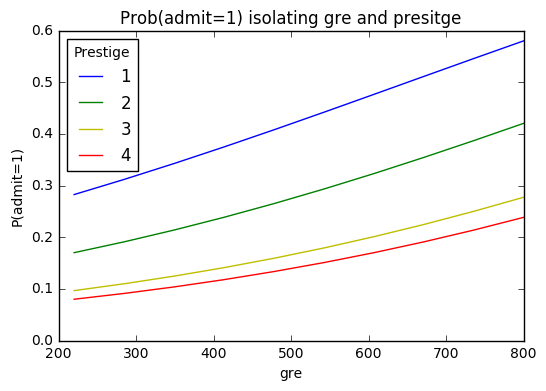

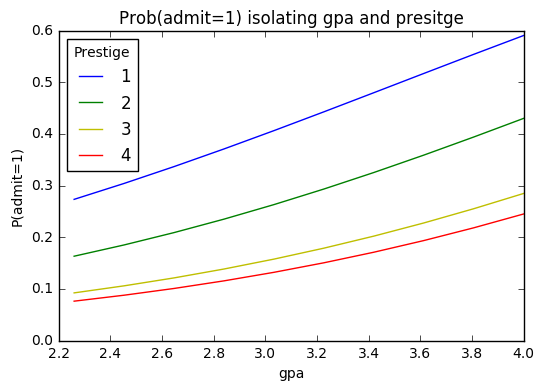

In [43]:
def isolate_and_plot(variable):
# isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                  aggfunc=np.mean)
# make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'], color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')